In [1]:
"""
scaling_experiment.py
---------------------
- Runs scaling experiments for BOTH EINet and MLP on the same dimension list.
- For each dimension 'dim', we set 'excitatory_branch_factors = [2, dim]'.
- We parse param_count and final loss from the experiment logs.
- Then plot them in log–log space on a single figure:
    x = log(param_count)
    y = log(loss)
  with separate curves for EINet vs MLP.
  
Usage Example:
  python scripts/scaling_experiment.py \
    --base_config .vscode/config_exp.yaml \
    --output_dir /n/holylabs/LABS/kempner_dev/Users/hsafaai/results/results_scaling \
    --dim_list 2 4 \
    --experiment_name_prefix scaling_exp
"""

import os
import sys
import json
import argparse
import yaml
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
# %% [markdown]
# # Scaling Experiment Notebook Cell
# 
# This cell contains the entire code to:
# 1) Define helper functions (`load_config_yaml`, `save_config_yaml`, 
#    `parse_experiment_logs`, `run_single_experiment`, `run_scaling_experiment`, `plot_loglog`).
# 2) Specify parameters for the scaling experiment.
# 3) Execute the experiments for both EINet and MLP with different "dim" values.
# 4) Save results to JSON.
# 5) Plot in log–log space (param_count vs final_loss).

# %%
import os
import sys
import json
import yaml
import matplotlib.pyplot as plt
from copy import deepcopy

# from IPython.display import display  # if you want to display images, logs, etc.

# Import the main training function (please ensure your PYTHONPATH is set)
# or that the dendritic_modeling package is accessible:
from dendritic_modeling.train_experiments import main as train_main


def load_config_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

def save_config_yaml(cfg_dict, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        yaml.dump(cfg_dict, f, sort_keys=False)

def parse_experiment_logs(exp_dir):
    """
    Parse param_count and final_loss from 'final_results.json' in exp_dir.
    This file is saved by our modified train_experiments.py 
    so it can be used in scaling experiments.
    """
    final_path = os.path.join(exp_dir, "final_results.json")
    if not os.path.exists(final_path):
        return None, None
    with open(final_path, 'r') as f:
        data = json.load(f)
    # e.g. { "param_count": 12345, "final_loss": 0.42, ... }
    param_count = data.get("param_count", None)
    final_loss  = data.get("final_loss", None)
    return param_count, final_loss

def run_single_experiment(config_base, output_dir, experiment_name):
    """
    Saves a temp config in `output_dir`, calls train_main,
    then parses logs for (param_count, final_loss).
    Returns (param_count, final_loss) or (None, None) if fail.
    """
    os.makedirs(output_dir, exist_ok=True)
    config_path = os.path.join(output_dir, "config.yaml")
    save_config_yaml(config_base, config_path)

    # Actually run the training
    try:
        train_main(config_path=config_path, output_dir=output_dir, experiment_name=experiment_name)
    except Exception as e:
        print(f"[ERROR] training failed: {e}")
        return None, None

    # Parse experiment logs
    pcount, loss = parse_experiment_logs(output_dir)
    return pcount, loss

def run_scaling_experiment(base_config_path, output_base_dir, dim_values,
                           experiment_name_prefix="scaling_exp"):
    """
    For each dim in dim_values, do 2 runs:
      1) EINet
      2) MLP
    Modify 'excitatory_branch_factors = [2, dim]' in config.
    Return a dictionary:
      results["EINet"] = list of { "dim":..., "param_count":..., "loss":... }
      results["MLP"]   = list of { "dim":..., "param_count":..., "loss":... }
    """
    os.makedirs(output_base_dir, exist_ok=True)

    base_cfg = load_config_yaml(base_config_path)

    results = {"EINet": [], "MLP": []}

    for dim in dim_values:
        for net_type in ["EINet", "MLP"]:
            cfg = deepcopy(base_cfg)

            # set the network type
            cfg["model"]["network"]["type"] = net_type

            # set excitatory_branch_factors = [2, dim]
            # (assuming your code picks that up properly)
            cfg["model"]["network"]["parameters"]["excitatory_branch_factors"] = [2, dim]

            # ensure we don't have mismatch in inhibitory factors
            cfg["model"]["network"]["parameters"]["inhibitory_branch_factors"] = []

            # Build a unique experiment dir
            exp_name = f"{experiment_name_prefix}_{net_type}_dim{dim}"
            exp_dir  = os.path.join(output_base_dir, exp_name)

            pcount, loss = run_single_experiment(cfg, exp_dir, exp_name)
            print(f"{net_type} {dim}")
            print(loss)
            if (pcount is not None) and (loss is not None):
                results[net_type].append({"dim": dim, "param_count": pcount, "loss": loss})
            else:
                print(f"[WARNING] Could not get param_count/loss for {net_type} dim={dim}")

    return results

def plot_loglog(results, output_dir, experiment_name_prefix):
    """
    We'll make a single plot with 2 curves (EINet vs MLP).
    x-axis = log(param_count)
    y-axis = log(loss)
    """
    plt.figure(figsize=(6,5))

    # We'll loop over the two keys
    for net_type, color, marker in [("EINet","blue","o"), ("MLP","red","s")]:
        data_list = results.get(net_type, [])
        # filter out entries missing param_count or loss
        data_list = [d for d in data_list if (d["param_count"] and d["loss"])]
        # sort by param_count to have a nice order
        data_list.sort(key=lambda x: x["param_count"])
        
        if len(data_list) == 0:
            continue

        x_param = [d["param_count"] for d in data_list]
        y_loss  = [d["loss"] for d in data_list]

        plt.xscale("log")
        plt.yscale("log")

        plt.plot(x_param, y_loss, marker=marker, color=color, label=net_type)

    plt.xlabel("Param Count (log)")
    plt.ylabel("Final Loss (log)")
    plt.title(f"Scaling: {experiment_name_prefix} (EINet vs MLP)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    savefig = os.path.join(output_dir, f"{experiment_name_prefix}_loglog.png")
    plt.savefig(savefig)
    plt.show()
    print(f"[INFO] Figure saved at {savefig}")

# %% [markdown]
# ### Example Usage in the Notebook
# 
# Below, we set up parameters, run the scaling experiment, save results to JSON,
# and plot the log–log figure.



In [3]:
# # 1) Set up your parameters
# BASE_CONFIG = "../.vscode/config_exp.yaml"  # Path to your base config
# OUTPUT_DIR  = "results_scaling"
# DIM_LIST    = [2, 4]  # example
# EXPERIMENT_NAME = "scaling_exp"

# os.makedirs(OUTPUT_DIR, exist_ok=True)
# base_cfg = load_config_yaml(BASE_CONFIG)
# base_cfg["model"]["network"]["type"] = "MLP"

# print(base_cfg)

# exp_name = f"{EXPERIMENT_NAME}_{"MLP"}_dim{4}"
# exp_dir  = os.path.join(OUTPUT_DIR, exp_name)

# pcount, loss = run_single_experiment(base_cfg, exp_dir, exp_name)


INFO logging_config.py:52  Log file set to results_scaling/scaling_exp_EINet_dim2/dendritic_modeling.log.
INFO train_experiments.py:102  Loading dataset...
Files already downloaded and verified
Files already downloaded and verified
INFO train_experiments.py:55  Running EINet with probabilistic classifier
INFO train_experiments.py:139  Using learning strategy: mle
INFO train_experiments.py:152  Saving results and visualizations to: /n/holylabs/LABS/kempner_dev/Users/hsafaai/results/dendritic_modeling/results/scaling_exp_EINet_dim2_2025-02-20_12-54-17
INFO train_experiments.py:188  Completed epoch 1/20
INFO train_experiments.py:188  Completed epoch 2/20
INFO train_experiments.py:188  Completed epoch 3/20
INFO train_experiments.py:188  Completed epoch 4/20
INFO train_experiments.py:188  Completed epoch 5/20
INFO train_experiments.py:188  Completed epoch 6/20
INFO train_experiments.py:188  Completed epoch 7/20
INFO train_experiments.py:188  Completed epoch 8/20
INFO train_experiments.py:18

/tmp/ipykernel_272147/471733641.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


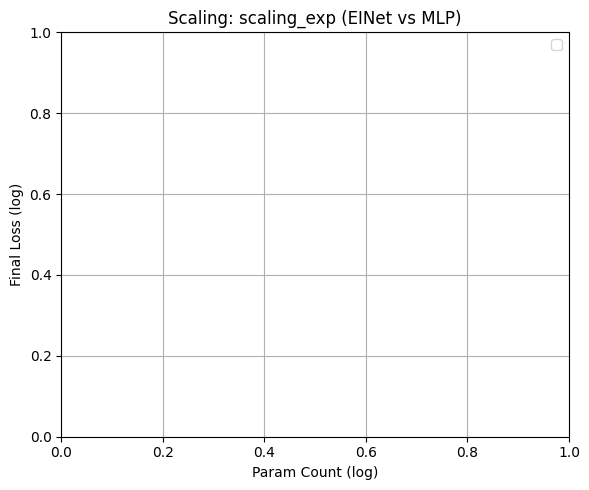

[INFO] Figure saved at results_scaling/scaling_exp_loglog.png
[DONE] All scaling runs complete and plotted.


In [4]:
# %%
# 1) Set up your parameters
BASE_CONFIG = "../.vscode/config_exp.yaml"  # Path to your base config
OUTPUT_DIR  = "results_scaling"
DIM_LIST    = [2, 4]  # example
EXPERIMENT_NAME = "scaling_exp"

# 2) Run experiments
results = run_scaling_experiment(
    base_config_path=BASE_CONFIG,
    output_base_dir=OUTPUT_DIR,
    dim_values=DIM_LIST,
    experiment_name_prefix=EXPERIMENT_NAME
)

# 3) Save to JSON
out_json = os.path.join(OUTPUT_DIR, f"{EXPERIMENT_NAME}_allresults.json")
os.makedirs(OUTPUT_DIR, exist_ok=True)
with open(out_json, "w") as f:
    json.dump(results, f, indent=2)
print(f"[INFO] Saved results => {out_json}")

# 4) Plot
plot_loglog(results, OUTPUT_DIR, EXPERIMENT_NAME)
print("[DONE] All scaling runs complete and plotted.")